# Import packages and load data

In [0]:
import pandas as pd
import numpy as np
import os
from itertools import product
import matplotlib.pyplot as plt
import time
import gc
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.linear_model
from sklearn import preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import xgboost
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras

%matplotlib inline 


In [10]:
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://github.com/ipovalyaev/competitive-data-science/raw/master/readonly/final_project_data/sales_train.csv.gz
      # https://api.github.com/repos/jakevdp/PythonDataScienceHandbook/contents/notebooks/data/california_cities.csv

transactions = pd.read_csv( 'sales_train.csv.gz')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   189  100   189    0     0    921      0 --:--:-- --:--:-- --:--:--   921
100 12.8M  100 12.8M    0     0  41.8M      0 --:--:-- --:--:-- --:--:-- 41.8M


In [0]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [0]:
train_test_split_block=34

# shop_ids = np.random.choice(transactions[transactions.date_block_num==train_test_split_block].shop_id.unique(),10)
shop_ids = transactions[transactions.date_block_num==train_test_split_block-1].shop_id.unique()


In [0]:
# time_window = 24
time_window = 13
n_features = 1

In [14]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

train_X = []
train_Y = []

for cur_seq_window in range(time_window,train_test_split_block):
    start_interval = cur_seq_window-time_window
    print(start_interval,cur_seq_window)
    #item_ids from Y
    # shop_ids = transactions[(transactions.date_block_num==cur_seq_window)].shop_id.unique()

    item_ids = transactions[
        (transactions.date_block_num==cur_seq_window) 
    ].item_id.unique()
    # grid for both X and Y
    v_grid_X = \
        cartesian_product(shop_ids, item_ids, np.array(range(cur_seq_window-time_window,cur_seq_window)))    
    pd_grid_X = pd.DataFrame(v_grid_X, columns = index_cols,dtype=np.int32)
    
    X_trans = transactions[
        (transactions.date_block_num>=start_interval) &
        (transactions.date_block_num<cur_seq_window) &
        (transactions.shop_id.isin(shop_ids)) & 
        (transactions.item_id.isin(item_ids))
    ]
    gb_X = X_trans.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
    pd_grid_val_X = pd.merge(pd_grid_X, gb_X, how='left', on=index_cols).fillna(0.0)    
    seq_num = int(pd_grid_val_X.shape[0]/time_window)
    print ("seq_num = " + str(seq_num))    
    np_X_chunk = np.reshape(pd_grid_val_X.sort_values(by=index_cols)['item_cnt_day'].values,
                                  (seq_num,time_window,n_features))
    
    
    v_grid_Y = cartesian_product(shop_ids, item_ids, np.array([cur_seq_window]))
    pd_grid_Y = pd.DataFrame(v_grid_Y, columns = index_cols,dtype=np.int32)    
    Y_trans = transactions[
        (transactions.date_block_num==cur_seq_window) &
        (transactions.shop_id.isin(shop_ids)) & 
        (transactions.item_id.isin(item_ids))
    ]
    gb_Y = Y_trans.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
    pd_grid_val_Y = pd.merge(pd_grid_Y, gb_Y, how='left', on=index_cols).fillna(0.0)
    
    np_Y_chunk = pd_grid_val_Y.sort_values(by=index_cols)['item_cnt_day'].values
    
    print ("np_X_chunk.shape = "+str(np_X_chunk.shape)+"np_Y_chunk.shape = "+str(np_Y_chunk.shape))


    
    if (cur_seq_window==train_test_split_block-1):
        ## test set
        test_X = np_X_chunk
        test_Y = np_Y_chunk
    else:
        ## train set
        train_X.append(np_X_chunk)
        train_Y.append(np_Y_chunk)
        
train_X_final = np.vstack(train_X)
train_Y_final = np.hstack(train_Y)

0 13
seq_num = 313896
np_X_chunk.shape = (313896, 13, 1)np_Y_chunk.shape = (313896,)
1 14
seq_num = 314248
np_X_chunk.shape = (314248, 13, 1)np_Y_chunk.shape = (314248,)
2 15
seq_num = 298056
np_X_chunk.shape = (298056, 13, 1)np_Y_chunk.shape = (298056,)
3 16
seq_num = 294140
np_X_chunk.shape = (294140, 13, 1)np_Y_chunk.shape = (294140,)
4 17
seq_num = 293964
np_X_chunk.shape = (293964, 13, 1)np_Y_chunk.shape = (293964,)
5 18
seq_num = 290884
np_X_chunk.shape = (290884, 13, 1)np_Y_chunk.shape = (290884,)
6 19
seq_num = 279972
np_X_chunk.shape = (279972, 13, 1)np_Y_chunk.shape = (279972,)
7 20
seq_num = 267124
np_X_chunk.shape = (267124, 13, 1)np_Y_chunk.shape = (267124,)
8 21
seq_num = 278696
np_X_chunk.shape = (278696, 13, 1)np_Y_chunk.shape = (278696,)
9 22
seq_num = 278168
np_X_chunk.shape = (278168, 13, 1)np_Y_chunk.shape = (278168,)
10 23
seq_num = 290620
np_X_chunk.shape = (290620, 13, 1)np_Y_chunk.shape = (290620,)
11 24
seq_num = 270116
np_X_chunk.shape = (270116, 13, 1)np_Y_ch

In [15]:
print(train_X_final.shape , train_Y_final.shape, test_X.shape , test_Y.shape)

(5389428, 13, 1) (5389428,) (238172, 13, 1) (238172,)


In [16]:
model = keras.Sequential()
model.add(keras.layers.CuDNNLSTM(256, input_shape=(train_X_final.shape[1], train_X_final.shape[2])
                                #  ,kernel_regularizer=keras.regularizers.l2(0.05)
                                #  ,recurrent_regularizer = keras.regularizers.l2(0.05)
                                ))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

history = model.fit(
    train_X_final, train_Y_final, 
    epochs=10, 
    batch_size=1024, 
    validation_data=(test_X, test_Y),
    verbose=2, 
    shuffle=True
)

Train on 5389428 samples, validate on 238172 samples
Epoch 1/10
5389428/5389428 - 51s - loss: 8.9836 - val_loss: 23.5724
Epoch 2/10
5389428/5389428 - 38s - loss: 7.9081 - val_loss: 22.9488
Epoch 3/10
5389428/5389428 - 38s - loss: 7.6834 - val_loss: 22.2439
Epoch 4/10
5389428/5389428 - 38s - loss: 7.4558 - val_loss: 21.6708
Epoch 5/10
5389428/5389428 - 38s - loss: 7.1971 - val_loss: 22.0389
Epoch 6/10
5389428/5389428 - 38s - loss: 7.0468 - val_loss: 21.3289
Epoch 7/10
5389428/5389428 - 38s - loss: 7.0297 - val_loss: 21.7341
Epoch 8/10
5389428/5389428 - 38s - loss: 7.0572 - val_loss: 21.3912
Epoch 9/10
5389428/5389428 - 38s - loss: 6.8822 - val_loss: 21.2894
Epoch 10/10
5389428/5389428 - 38s - loss: 6.7848 - val_loss: 21.4806


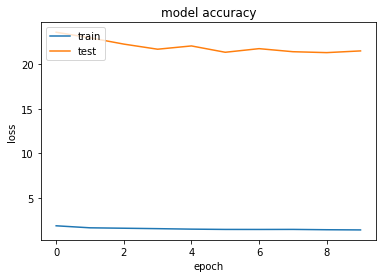

In [17]:
sc = np.sqrt(train_X_final.shape[0]/test_X.shape[0])
plt.plot(history.history['loss']/sc)
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()